# Nomad Advanced Job Placement

teaser: |
Explore advanced Nomad job placement strategies with Constraints, Affinities, and Spread.

description: |-
This track will show how you can control job placement in Nomad with:
- [Constraints](https://www.nomadproject.io/docs/job-specification/constraint/)
- [Affinities](https://www.nomadproject.io/docs/job-specification/affinity/)
- and [Spread](https://www.nomadproject.io/docs/job-specification/spread/)
- illustrating the flexibility of Nomad in this area.

You will also learn about Nomad's [Variable Interpolation](https://www.nomadproject.io/docs/runtime/interpolation/) that allow applications deployed by Nomad to do things like use listen on ports dynamically selected by Nomad.

You will deploy a Nomad cluster and run Nomad jobs that deploy a web application and [Traefik](https://containo.us/traefik/), which will provide load balancing across multiple instances of the application.

Before running this track, we suggest you run the **Nomad Basics** and **Nomad Simple Cluster** tracks.

<img src=https://storage.googleapis.com/instruqt-hashicorp-tracks/logo/nomad.png width=100>


# Prep

## AWS Credentials

Set your AWS Credentials. I got one from Instruqt terminal with this command.

```bash
env | grep -iE "^aws.*access" | xargs -I{} echo export {}
```

In [ ]:
unset AWS_ACCESS_KEY_ID AWS_SECRET_ACCESS_KEY
export AWS_DEFAULT_REGION=us-west-2
export AWS_REGION=$AWS_DEFAULT_REGION
export AWS_ACCESS_KEY_ID=
export AWS_SECRET_ACCESS_KEY=
export TF_VAR_aws_access_key_id=$AWS_ACCESS_KEY_ID
export TF_VAR_aws_secret_access_key=$AWS_SECRET_ACCESS_KEY
export TF_INPUT=false

printf "%s\n" "==> Creds:" "$AWS_REGION" "$AWS_ACCESS_KEY_ID" "$AWS_SECRET_ACCESS_KEY"

Create default VPC if needed.

In [ ]:
aws configure set region us-west-2 --profile default

In [ ]:
aws ec2 create-default-vpc > /dev/null || true

# printf "\n==> Create VPC - Nomad\n"
# if [[ -z $(aws ec2 describe-vpcs \
#   | jq -r '.[] | .[] | select(.IsDefault == false ) | .VpcId ') ]]; then
#   echo "Creating VPC"
#   aws ec2 create-vpc \
#     --cidr-block 172.33.0.0/24 \
#     --tag-specification ResourceType=vpc,Tags=['{Key=Name,Value=Nomad}']
# fi

printf "\n#==> Show VPC ids\n"
aws ec2 describe-vpcs \
  | jq -r '.[] | .[] | select(.IsDefault == true ) | .VpcId '

## Clone Repo

In [ ]:
pushd /tmp >/dev/null
git clone https://github.com/phanclan/nomad_terraform
# cp -r /tmp/nomad/terraform /tmp/Nomad
popd >/dev/null

In [ ]:
# rm -rf /tmp/Nomad/{ssh_key,cluster} 

mkdir -p /tmp/nomad_terraform/ssh_key
# mkdir -p /tmp/nomad_terraform/cluster

## create terragrunt.hcl - ssh_key

In [ ]:
cat > /tmp/nomad_terraform/ssh_key/terragrunt.hcl <<"EOL"
terraform {
  source = "tfr:///cloudposse/key-pair/aws?version=0.18.3"
  extra_arguments "plan" {
    commands = [ "plan", ]
    arguments = [
      "-input=false",
    ]
  }
  extra_arguments "apply" {
    commands = [ "apply", "destroy" ]
    arguments = [
      "-input=false",
      "-auto-approve"
    ]
  }
}

# Indicate the input values to use for the variables of the module.
inputs = {
  ssh_public_key_path       = "/tmp/nomad_terraform/ssh_key"
  generate_ssh_key     = true
  name                 = "aws-key-pair"
}
EOL

In [ ]:
pushd /tmp/nomad_terraform/ssh_key >/dev/null
time terragrunt apply > tf_apply_ssh_key_out.txt 2>&1 &
popd >/dev/null

In [ ]:
tail /tmp/nomad_terraform/ssh_key/tf_apply_ssh_key_out.txt

In [ ]:
pushd /tmp/nomad_terraform/ssh_key >/dev/null
printf "private key: $(terragrunt output -raw private_key_filename)"
popd >/dev/null

## create terragrunt.hcl - cluster

### packer

In [ ]:
pushd /tmp/nomad_terraform/aws >/dev/null
cat > packer.json <<EOL
{
  "builders": [{
    "type": "amazon-ebs",
    "region": "us-west-2",
    "source_ami_filter": {
      "filters": {
        "virtualization-type": "hvm",
        "architecture": "x86_64",
        "name": "ubuntu/images/hvm-ssd/ubuntu-focal-20.04-amd64-server-*",
        "root-device-type": "ebs"
      },
      "owners": ["099720109477"],
      "most_recent": true
    },
    "instance_type": "m5.large",
    "ssh_username": "ubuntu",
    "ami_name": "hashistack {{timestamp}}"
  }],
  "provisioners":  [
  {
    "type": "shell",
    "inline": [
      "sudo mkdir /ops",
      "sudo chmod 777 /ops"
    ]
  },
  {
    "type": "file",
    "source": "../shared",
    "destination": "/ops"
  },
  {
    "type": "file",
    "source": "../examples",
    "destination": "/ops"
  },
  {
    "type": "shell",
    "script": "../shared/scripts/setup_new.sh",
    "environment_vars": [
      "INSTALL_NVIDIA_DOCKER=false"
    ]
  }]
}
EOL
popd >/dev/null

#### packer build

> My build time was ~6 minutes.

In [ ]:
pushd /tmp/nomad_terraform/aws >/dev/null
time packer build packer.json > /tmp/packer_nomad_out.txt 2>&1
popd >/dev/null

In [ ]:
tail -n 30 /tmp/packer_nomad_out.txt

### terraform configs

Get the ami id for your `ami` variable. Copy it for the next step.

In [ ]:
grep ami /tmp/packer_nomad_out.txt | tail -n 1 | awk '{print $NF}'

Customize the inputs below. Use the `ami` value above

In [ ]:
cat > /tmp/nomad_terraform/aws/env/terragrunt.hcl <<"EOL"
terraform {
  #source = "git::https://github.com/hashicorp/nomad.git//terraform/aws/modules/hashistack"
  extra_arguments "plan" {
    commands = [ "plan", ]
    arguments = [
      "-input=false",
    ]
  }
  extra_arguments "apply" {
    commands = [ "apply", "destroy", ]
    arguments = [
      "-input=false",
      "-auto-approve"
    ]
  }
}

generate "versions" {
  path = "versions.tf"
  if_exists = "overwrite"
  contents = <<EOF
terraform {
  # required_version = "~1.1.0"
  required_providers{
    aws = {
      source = "hashicorp/aws"
      version = "~> 3.75.2"
    }
  }
}
EOF
}

generate "provider" {
  path = "provider.tf"
  if_exists = "overwrite"
  contents = <<EOF
provider "aws" {
  region = "us-west-2"   # region to deploy the resources into
}
EOF
}

#// Indicate the input values to use for the variables of the module.
inputs = {
  name          = "pphan"
  region        = "us-west-2"
  ami           = "ami-0dbf7c569799e75d0"   #<==---
  server_instance_type  = "m5.large"
  client_instance_type  = "m5.xlarge"
  server_count  = 3
  client_count  = 1
  key_name      = "aws-key-pair"
  whitelist_ip  = "98.234.158.216/32"
  root_block_device_size = 16
  nomad_binary           = "none"
#   consul_version = "1.13.1"
#   nomad_version  = "1.3.5"
#   owner          = "pphan"
#   vpc_id         = "vpc-0a3da3e09494785db"
#   #//optional
#   public_ip      = true
#   #consul_config = {}
#   tags = {
#     Terraform   = "true"
#     Environment = "root"
#     Name        = "Terragrunt-${path_relative_to_include()}"
#   }
}

EOL
echo done

In [ ]:
cat > /tmp/nomad_terraform/aws/env/main.tf <<"EOL"
module "hashistack" {
  source = "../modules/hashistack"
  name                   = var.name
  region                 = var.region
  ami                    = var.ami
  server_instance_type   = var.server_instance_type
  client_instance_type   = var.client_instance_type
  key_name               = var.key_name
  server_count           = var.server_count
  client_count           = var.client_count
  retry_join             = var.retry_join
  nomad_binary           = var.nomad_binary
  root_block_device_size = var.root_block_device_size
  whitelist_ip           = var.whitelist_ip
}

variable "name" {
  description = "Used to name various infrastructure components"
}
variable "whitelist_ip" {
  description = "IP to whitelist for the security groups (set 0.0.0.0/0 for world)"
}
variable "region" {}
variable "ami" {}
variable "server_instance_type" {}
variable "client_instance_type" {}
variable "root_block_device_size" {}
variable "key_name" {}
variable "server_count" {}
variable "client_count" {}
variable "retry_join" {
  type = map(string)
  default = {
    provider  = "aws"
    tag_key   = "ConsulAutoJoin"
    tag_value = "auto-join"
  }
}
variable "nomad_binary" {}
EOL

In [ ]:
cat > /tmp/nomad_terraform/aws/env/outputs.tf <<"EOL"
output "IP_Addresses" {
  value = <<CONFIGURATION
Client public IPs: ${join(", ", module.hashistack.client_public_ips)}
Server public IPs: ${join(", ", module.hashistack.server_public_ips)}
To connect, add your private key and SSH into any client or server with
`ssh ubuntu@PUBLIC_IP`. You can test the integrity of the cluster by running:
  $ consul members
  $ nomad server members
  $ nomad node status
If you see an error message like the following when running any of the above
commands, it usually indicates that the configuration script has not finished
executing:
"Error querying servers: Get http://127.0.0.1:4646/v1/agent/members: dial tcp
127.0.0.1:4646: getsockopt: connection refused"
Simply wait a few seconds and rerun the command if this occurs.
The Nomad UI can be accessed at http://${module.hashistack.server_lb_ip}:4646/ui.
The Consul UI can be accessed at http://${module.hashistack.server_lb_ip}:8500/ui.
Set the following for access from the Nomad CLI:
  export NOMAD_ADDR=http://${module.hashistack.server_lb_ip}:4646
CONFIGURATION
}
output "consul_http_addr" {
  value = "http://${module.hashistack.server_lb_ip}:8500"
}
output "nomad_addr" {
  value = "http://${module.hashistack.server_lb_ip}:4646"
}
output "client_public_ips_2" {
  value = module.hashistack.client_public_ips_2
}
EOL

#### extra clients

- https://aws.amazon.com/ec2/spot/pricing/


In [ ]:
cat > /tmp/nomad_terraform/aws/modules/hashistack/client2.tf <<"EOL"
resource "aws_spot_instance_request" "client2" {
  ami                    = var.ami
  spot_price             = "0.14" #<==---spot
  wait_for_fulfillment   = true   #<==---spot
  instance_type          = "m5.large"
  key_name               = var.key_name
  vpc_security_group_ids = [aws_security_group.primary.id]
  count                  = 2
  depends_on             = [aws_instance.server]
  ipv6_address_count     = 0
  ipv6_addresses         = []

  # instance tags
  tags = merge(
    {
      "Name" = "${var.name}-client-${count.index}"
    },
    {
      "${var.retry_join.tag_key}" = "${var.retry_join.tag_value}"
    },
  )

  root_block_device {
    volume_type           = "gp3"
    volume_size           = var.root_block_device_size
    delete_on_termination = "true"
  }

  ebs_block_device {
    device_name           = "/dev/xvdd"
    volume_type           = "gp3"
    volume_size           = "50"
    delete_on_termination = "true"
  }

  user_data = templatefile("${path.root}/user-data-client.sh",
    {
      region = var.region
      retry_join = chomp(
        join(
          " ",
          formatlist("%s=%s ", keys(var.retry_join), values(var.retry_join)),
        ),
      )
      nomad_binary = var.nomad_binary
    }
  )
  iam_instance_profile = aws_iam_instance_profile.instance_profile.name
}
output "client_public_ips_2" {
  value = aws_spot_instance_request.client2[*].public_ip
}
EOL

### copy user-data scripts

In [ ]:
pushd /tmp/nomad_terraform/aws/env >/dev/null
cp ./us-east/user-data-*.sh .
popd >/dev/null

### terraform init

This takes a minute. It's quick because packer did all the hard work creating the golden image.

In [ ]:
pushd /tmp/nomad_terraform/aws/env >/dev/null
terragrunt init -upgrade -force-copy
popd >/dev/null

### terraform apply

In [ ]:
pushd /tmp/nomad_terraform/aws/env
time terragrunt apply > /tmp/tf_apply_nomad_out.txt 2>&1
popd

In [ ]:
tail -n 50 /tmp/tf_apply_nomad_out.txt

## set nomad and consul variables

In [ ]:
pushd /tmp/nomad_terraform/aws/env >/dev/null
export NOMAD_ADDR=$(terragrunt output -raw nomad_addr)
export CONSUL_HTTP_ADDR=$(terragrunt output -raw consul_http_addr)
export VAULT_ADDR=http://pphan-server-lb-920687407.us-west-2.elb.amazonaws.com:8200

printf "%s\n" "Nomad UI: $NOMAD_ADDR" "Consul UI:$CONSUL_HTTP_ADDR"
popd >/dev/null

In [ ]:
pushd /tmp/nomad_terraform/aws/env >/dev/null
terragrunt output -json client_public_ips_2 | jq -r .[0]
# export NOMAD_ADDR=$(terragrunt output -raw nomad_addr)
# export NOMAD_ADDR=http://pphan-server-lb-2092905469.us-west-2.elb.amazonaws.com:4646
# printf "%s\n" "Nomad UI: $NOMAD_ADDR" "Consul UI:$CONSUL_HTTP_ADDR"
popd >/dev/null

- slug: verify-nomad-cluster-health

# Verify the Health of Your Nomad Cluster

teaser: |
    Verify the health of the Nomad cluster that has been deployed for you.

## notes:

In this challenge, you will verify the health of the Nomad cluster that has been deployed for you by the track's setup scripts. This will include checking the health of a Consul cluster that has been set up on the same VMs.

In later challenges, you will run Nomad jobs that deploy a web application and the Traefik load balancer. You will then update them using Nomad's various options for controlling job placement.

---

In this challenge, you will verify the health of the Nomad cluster that has been deployed for you by the track's setup scripts. This will include checking the health of a Consul cluster that has been set up on the same VMs.

The cluster is running:
- 3 Nomad/Consul server
- 3 Consul clients
- 1 Nomad xlarge client
- 2 Nomad large clients

They are using software versions:
| Software | Version |
| --- | --- |
| Nomad | 1.3.4 |
| Consul | 1.12.4 |

First, verify that all 6 Consul agents are running and connected to the cluster:

In [ ]:
consul members

You should see 6 Consul agents with the "`alive`" status.

```
Node              Address             Status  Type    Build   Protocol  DC   Partition  Segment
ip-172-31-32-161  172.31.32.161:8301  alive   server  1.12.2  2         dc1  default    <all>
ip-172-31-35-92   172.31.35.92:8301   alive   server  1.12.2  2         dc1  default    <all>
ip-172-31-46-21   172.31.46.21:8301   alive   server  1.12.2  2         dc1  default    <all>
ip-172-31-36-155  172.31.36.155:8301  alive   client  1.12.2  2         dc1  default    <default>
ip-172-31-38-164  172.31.38.164:8301  alive   client  1.12.2  2         dc1  default    <default>
ip-172-31-46-251  172.31.46.251:8301  alive   client  1.12.2  2         dc1  default    <default>
```

Check that the Nomad server is running:

In [ ]:
nomad server members

You should see 3 Nomad servers with the "`alive`" status.
```
Name                     Address        Port  Status  Leader  Raft Version  Build  Datacenter  Region
ip-172-31-32-161.global  172.31.32.161  4648  alive   false   3             1.3.1  dc1         global
ip-172-31-35-92.global   172.31.35.92   4648  alive   false   3             1.3.1  dc1         global
ip-172-31-46-21.global   172.31.46.21   4648  alive   true    3             1.3.1  dc1         global
```

Check the status of the Nomad client nodes:

In [ ]:
nomad node status

You should see 3 Nomad clients with the "`ready`" status.

```
ID        DC   Name              Class   Drain  Eligibility  Status
ba90fa7e  dc1  ip-172-31-36-155  <none>  false  eligible     ready
48d0b218  dc1  ip-172-31-38-164  <none>  false  eligible     ready
6f750cb2  dc1  ip-172-31-46-251  <none>  false  eligible     ready
```

You can also check the status of the Nomad server and clients in the Nomad and Consul UIs.

In [ ]:
printf "%s\n" "Consul UI: $CONSUL_HTTP_ADDR" "Nomad UI: $NOMAD_ADDR"

In the next challenge, you will run jobs that deploy a web application and the Traefik load balancer.

---

- slug: deploy-the-jobs

# Deploy a Web Application and Traefik with Nomad

teaser: |
Deploy a web application and Traefik with Nomad jobs.

## notes:

In this challenge, you will run Nomad jobs that deploy a web application and [Traefik](https://containo.us/traefik/), which will serve as a load balancer in front of multiple instances of the web app.

In later challenges, you will learn about Nomad Spread, Constraints, and Affinities.

---

In this challenge, you will run two Nomad jobs:
* The first will deploy 6 instances of a web app.
* The second will run Traefik as a load balancer for the web app.

## Inspect the webapp.nomad Job.

Let's begin by inspecting the Nomad jobs and getting familiar with what you're going to deploy.

Inspect the "`webapp.nomad`" job specification file.

In [ ]:
mkdir -p /tmp/nomad_terraform/jobs
cat > /tmp/nomad_terraform/jobs/webapp.nomad <<-EOF
job "webapp" {
  datacenters = ["dc1"]
  group "webapp" {
    count = 6
    network {
      port  "http" {}
    }
    task "server" {
      env {
        PORT    = "\${NOMAD_PORT_http}"
        NODE_IP = "\${NOMAD_IP_http}"
      }
      driver = "docker"
      config {
        image = "hashicorp/demo-webapp-lb-guide"
        ports = ["http"]
      }
      resources {
        cpu    = 20
        memory = 678
      }
      service {
        name = "webapp"
        port = "http"
        tags = [
          "traefik.tags=service",
          "traefik.frontend.rule=PathPrefixStrip:/myapp",
        ]
        check {
          type     = "http"
          path     = "/"
          interval = "2s"
          timeout  = "2s"
        }
      }
    }
  }
}
EOF

- This will deploy 6 instances of our web app to your Nomad cluster since the `count` of the "`webapp`" task group is set to 6.
- Note, however, that we have not yet used any of the job placement stanzas mentioned in this track's description.
    - So, Nomad is free to place the 6 instances wherever it wants.

Since the job specification does not specify a static port to use, Nomad will select a dynamic port for each web app instance.
- This allows us to run more than one instance of the web app on each Nomad client.
- In contrast, if we had specified a static port, we could only have run one instance per Nomad client.

Since we are using dynamic ports, each instance of the web app has to listen on the right port.
- The job enables them to do that with [variable interpolation](https://nomadproject.io/docs/runtime/interpolation/)
- the job sets the `PORT` and `NODE_IP` environment variables to `${NOMAD_PORT_http}` and `${NOMAD_IP_http}` respectively.
- When each instance of the web app starts, it can read those environment variables and bind to the correct IP and port.
    - This is achieved in combination with the [port parameters](https://nomadproject.io/docs/job-specification/network/#port-parameters) in the network stanza of the job specification.

## Run the webapp.nomad Job

Navigate to the `/tmp/nomad_terraform/jobs` directory:

In [ ]:
cd /tmp/nomad_terraform/jobs

Run the "`webapp.nomad`" job with this command on the "`Server`" tab:

In [ ]:
nomad job run webapp.nomad > /tmp/nomad_job_run.txt 2>&1 &

In [ ]:
tail -n 50 /tmp/nomad_job_run.txt

This should return something like this:

```
==> Monitoring evaluation "a05672bc"
Evaluation triggered by job "webapp"
Evaluation within deployment: "5692a28d"
Allocation "6bc9d9e6" created: node "33fd8505", group "webapp"
Allocation "1b90c684" created: node "3006bb6d", group "webapp"
Allocation "56b0671c" created: node "2f4a35ac", group "webapp"
Evaluation status changed: "pending" -> "complete"
==> Evaluation "a05672bc" finished with status "complete"
```

### Verify

You can check the status of the job by selecting the "`webapp`" job on the "Nomad UI" tab.

In [ ]:
printf "%s\n" "Nomad UI: $NOMAD_ADDR"

After about 1 minute, you should see that the job has 6 healthy allocations, each representing a single instance of the web app.

Check the status of the job with the Nomad CLI:

In [ ]:
nomad job status webapp

You can also inspect the "`Consul UI`" tab to see the health of the web app instances that have all been registered as services in Consul.

In [ ]:
printf "%s\n" "Consul UI: $CONSUL_HTTP_ADDR"

- Click on the "`webapp`" service.
    - Note how the instances are spread across the clients.
- They might or might not be evenly distributed since we did not specify any job placement stanzas.

## Inspect the traefik.nomad Job

Inspect the "`traefik.nomad`" job specification file.

In [ ]:
cat > /tmp/nomad_terraform/jobs/traefik.nomad <<-EOF
job "traefik" {
  region      = "global"
  datacenters = ["dc1"]
  type        = "service"
  group "traefik" {
    count = 1
    network {
      port "http" {
        static = 8080
      }
      port "api" {
        static = 8081
      }
    }
    task "traefik" {
      driver = "docker"
      config {
        image        = "traefik:1.7"
        network_mode = "host"
        volumes = [
          "local/traefik.toml:/etc/traefik/traefik.toml",
        ]
      }
      template {
        data = <<EOD
[entryPoints]
    [entryPoints.http]
    address = ":8080"
    [entryPoints.traefik]
    address = ":8081"
[api]
    dashboard = true
# Enable Consul Catalog configuration backend.
[consulCatalog]
endpoint = "127.0.0.1:8500"
domain = "consul.localhost"
prefix = "traefik"
constraints = ["tag==service"]
EOD
        destination = "local/traefik.toml"
      }
      resources {
        cpu    = 250
        memory = 128
      }
      service {
        name = "traefik"
        check {
          name     = "alive"
          type     = "tcp"
          port     = "http"
          interval = "10s"
          timeout  = "2s"
        }
      }
    }
  }
}
EOF

What does this job file do?
- This will deploy a Docker container that runs Traefik
- Traefik proxies all requests to the web app instances on port `8080` to their dynamic ports allocated by Nomad.
- This job uses Nomad's [template](https://www.nomadproject.io/docs/job-specification/template/) stanza to write out a Traefik configuration file, "`traefik.toml`"
    - Traefik will read this when started.
    - The template includes Traefik's [constraints config](https://docs.traefik.io/providers/consul-catalog/#constraints) for Consul's services catalog with this setting:

```
constraints = ["tag==service"]
```

If you look back at the "`webapp.nomad`" job specification, on line 34 you will see that the same service tag was specified in the `tags` section of the registration of the web app with Consul.

```
tags = [
"traefik.tags=service",
"traefik.frontend.rule=PathPrefixStrip:/myapp",
]
```

We think it's pretty cool that:
- Nomad deploys both jobs
- and registers them as Consul services
- and that Traefik then uses the registrations of the web app instances with Consul to determine how to direct traffic to them.

## Run the traefik.nomad Job

Run the "`traefik.nomad`" job with this command on the "`Server`" tab:

In [ ]:
nomad job run traefik.nomad > /tmp/nomad_job_run_traefik.txt 2>&1 &

In [ ]:
time head -n 10 /tmp/nomad_job_run_traefik.txt

This should return something like this:

```
==> Monitoring evaluation "6765c131"
    Evaluation triggered by job "traefik"
    Evaluation within deployment: "d15e6190"
    Allocation "0e36e38a" created: node "44d88b4b", group "traefik"
    Evaluation status changed: "pending" -> "complete"
==> Evaluation "6765c131" finished with status "complete"
```

As before, you can check the status of the job by selecting the "`traefik`" job on the "Nomad UI" tab.

Check the status of the job with the Nomad CLI by running this command on the "`Server`" tab:

In [ ]:
nomad job status traefik

**NEED TO MAKE APPLICABLE OUTSIDE OF INSTRUQT**

Unfortunately, you cannot load the web app or Traefik UIs yet because we have not exposed Instruqt tabs for them.
- We would have had to add tabs exposing port `8081` on all 3 Nomad clients in order to expose the Traefik dashboard since we could not predict in advance which Nomad client Traefik would be deployed to with the current "`traefik.nomad`" job specification.

We will fix this in the next challenge.


---

- slug: use-constraint

# Use Nomad's Constraint Stanza

teaser: |

Use Nomad's constraint stanza to tightly control the placement of the Traefik job.

## notes:

In this challenge, you will update the Traefik job to run on a specific Nomad client node so that you can visit the Traefik Dashboard on a new Instruqt tab.

You will do this by using Nomad's [constraint](https://www.nomadproject.io/docs/job-specification/constraint/) stanza that allows Nomad operators to tightly control the placement of a job's allocations.

assignment:

In this challenge, you will use Nomad's [constraint](https://www.nomadproject.io/docs/job-specification/constraint/) stanza to restrict Traefik to run on a specific Nomad client.

We will be using a constraint that filters on a [node variable](https://www.nomadproject.io/docs/runtime/interpolation/#node-variables) of the Nomad client nodes, but you could also use [client metadata](https://www.nomadproject.io/docs/configuration/client#custom-metadata-network-speed-and-node-class).

Please navigate back to the `/tmp/nomad_terraform/jobs` directory on the "`Server`" tab:

In [ ]:
cd /tmp/nomad_terraform/jobs

## Edit the traefik.nomad Job Specification

Edit the "`traefik.nomad`" job specification file on the "`Jobs`" tab, making the following changes:

First, grab a node to deploy the job to.

In [ ]:
TRAEFIK_NODE=$(nomad node status | tail -n 1 | awk '{print $3}')
echo $TRAEFIK_NODE

Find the line with `count = 1` and add the following constraint stanza after it:

```go
constraint {
  attribute = "${node.unique.name}"
  value     = "client1"
}
```

If you prefer, you can do the editing with this command on the "`Server`" tab:

In [ ]:
mv traefik.nomad.bak_$(date +%Y%m%d) traefik.nomad
ls -lrt
sed -i".bak_$(date +%Y%m%d)" "s/count = 1/count = 1\n\n\
      constraint { \n \
        attribute = \"\${node.unique.name}\"\n \
        value     = \"${TRAEFIK_NODE}\"\n \
      }/g" \
  traefik.nomad
cat traefik.nomad

## Re-run the traefik.nomad Job

Next, re-run the "`traefik.nomad`" job with this command on the "Server" tab:

In [ ]:
time nomad job run traefik.nomad > /tmp/nomad_job_run_traefik.txt 2>&1 &

In [ ]:
(head ; tail) < /tmp/nomad_job_run_traefik.txt


This should return something like this:<br>
```
==> Monitoring evaluation "63a2e467"
    Evaluation triggered by job "traefik"
    Evaluation within deployment: "662516d9"
    Allocation "b42c964c" created: node "99187f90", group "traefik"
    Evaluation status changed: "pending" -> "complete"
==> Evaluation "63a2e467" finished with status "complete"
```

## Verify

- Look at the "`traefik`" job in the Nomad UI
  - You will see that there is 1 allocation currently `running`.
  - Click on the ID of that allocation in the `Client` column.
  - You will be taken to the "`client1`" node.

This shows that the `constraint` worked as desired.

In [ ]:
#DEBUGGING
nomad node status
nomad job status traefik

### **NEED TO ADD RULE TO ALLOW ALL FROM MY IP**

**FOR TESTING ONLY**

Now, you can visit the Traefik dashboard on the "`Traefik UI`" tab.

In [ ]:
TRAEFIK_NODE_PUBLIC=$(aws ec2 describe-instances \
  | jq -r ".Reservations[].Instances[] \
  | select(.PrivateDnsName | contains(\"${TRAEFIK_NODE}\")) | .PublicIpAddress")

echo Traefik UI: http://${TRAEFIK_NODE_PUBLIC}:8081

- You can see the URLs for the 6 instances of the web app that it has registered.
- This URL was pre-configured to point to the `${TRAEFIK_NODE}`, since we set it in advance with `constraint`.
- It accesses that node on port `8081` which is Traefik's admin port.

Right-click any of those URLs in the "`backend-webapp`" table
- Select "`Copy Link Address`".
- Then run a command like this
```shell
curl <your_url>
```
    - where `<your_url>` is the URL you copied.

In [ ]:
ssh -i /tmp/nomad_terraform/ssh_key/aws-key-pair \
  -o "StrictHostKeyChecking no" ubuntu@${TRAEFIK_NODE_PUBLIC} \
  curl -s http://172.31.18.225:27198/

- You should see something like this:<br>
`Welcome! You are on node 10.132.0.66:20478`

By specifying the IP and the port that Nomad dynamically selected, you are hitting one of the webapp allocations directly just as Traefik does.

Next, run the following `curl` command:

In [ ]:
curl http://${TRAEFIK_NODE_PUBLIC}:8080/myapp

This will return a similar message.

In this case, you are actually hitting Traefik on Nomad client 1 and it is load balancing your request to one of the 6 webapp instances.

If you repeat the command a few times, you will see that the IP and port returned are different each time.

In [ ]:
for i in {1..6}; do
curl http://${TRAEFIK_NODE_PUBLIC}:8080/myapp
done

You can also visit the web app on the "`Web App UI`" tab.
- This tab also points to the `nomad-client-1` node but listens on port `8080` which is what Traefik is using to load balance requests to the web app.
- You will see the same message that the `curl` command gave.
- If you click the Instruqt refresh button (clockwise arrow) to the right of the "`Web App UI`" tab, the IP and port displayed will also change.

In the next challenge, you will use Nomad's spread stanza to distribute the allocations of your "`webapp.nomad`" job evenly across your 3 Nomad clients.

---

- slug: use-spread
  
# Use Nomad's Spread stanza

  teaser: |
    Use Nomad's spread stanza to distribute load evenly across your Nomad clients.

## notes:

In this challenge, you will update the logic that Nomad uses to distribute allocations of the web app to the 3 Nomad clients in your cluster.

Specifically, you will use the [spread](https://www.nomadproject.io/docs/job-specification/spread/) stanza to evenly distribute allocations of the web app across all 3 Nomad clients.

assignment: |-

In this challenge, you will use Nomad's [spread](https://www.nomadproject.io/docs/job-specification/spread/) stanza to spread the "`webapp.nomad`" job's allocations evenly across the 3 Nomad clients of your cluster.

This demonstrates how Nomad can increase the failure tolerance of applications.

The `spread` stanza allows operators to spread allocations over datacenters, availability zones, or even racks in a physical datacenter. By default, when using `spread`, the scheduler will attempt to place allocations equally among the available values of the given target.

## Edit the webapp.nomad Job

Navigate back to the `/tmp/nomad/jobs` directory on the "`Server`" tab:

In [ ]:
cd /tmp/nomad_terraform/jobs

Edit the "`webapp.nomad`" job specification file on the "`Jobs`" tab, making the following changes:

Find the line that has `count = 6` and add the following spread stanza after it:

```go
spread {
  attribute = "${node.unique.name}"
}
```

If you prefer, you can do the editing with this command on the "`Server`" tab:

In [ ]:
mv webapp.nomad.bak_$(date +%Y%m%d) webapp.nomad
ls -lrt

sed -i".bak_$(date +%Y%m%d)" \
  's/count = 6/count = 6\n\
    spread { \
      attribute = "${node.unique.name}" \
    }/g' \
  webapp.nomad
head -n 10  webapp.nomad

**NOTE**:
- We do not specify a `value` the way we did in the `constraint` stanza in the last challenge.
- The whole point here is to spread allocations evenly across all Nomad clients based on their names.

**PP - ADD MORE INFO**

You can view the current allocations for the "`webapp`" job.
- select the `webapp` job in the Nomad UI
- click on the "`Allocations`" tab under the job
- In the Nomad UI, focus on the "`Client`" column.
- CLI
    - or by running `nomad job status webapp`
    - and looking at the "`Allocations`" section at the bottom of the output.
    ```text
    ...
    Allocations
    ID        Node ID   Task Group  Version  Desired  Status   Created    Modified
    36655ee2  69bb47a1  webapp      0        run      running  13m8s ago  12m29s ago
    37ea648c  71670de6  webapp      0        run      running  13m8s ago  12m32s ago
    49874897  f3d852dd  webapp      0        run      running  13m8s ago  12m33s ago
    73498c1a  71670de6  webapp      0        run      running  13m8s ago  12m31s ago
    90263f17  69bb47a1  webapp      0        run      running  13m8s ago  12m30s ago
    cddf807a  69bb47a1  webapp      0        run      running  13m8s ago  12m28s ago    
    ```
    - Focus on the "`Node ID`" column. The allocations might or might not be evenly distributed across the 3 Nomad clients

## Re-run the webapp.nomad job

Now let's re-run the "`webapp.nomad`" job and see the changes that occur:

In [ ]:
time nomad job run webapp.nomad > /tmp/nomad_job_run.txt 2>&1 &

In [ ]:
(head -n 10 ; echo ; tail -n 15) < /tmp/nomad_job_run.txt

- Monitor the new deployment of the job in the Nomad UI
- Or by periodically re-running `nomad job status webapp`.
- Pay particular attention to `running` allocations.

In [ ]:
nomad job status webapp

After all six allocations are healthy, you should see 2 webapp allocations on each Nomad client.

Sample Output
```shell
Allocations
ID        Node ID   Task Group  Version  Desired  Status    Created     Modified
6d4e5a11  69bb47a1  webapp      1        run      running   8m ago      7m48s ago
83dd87eb  71670de6  webapp      1        run      running   8m16s ago   8m1s ago
c74711fe  f3d852dd  webapp      1        run      running   8m29s ago   8m17s ago
2e6adccf  69bb47a1  webapp      1        run      running   8m44s ago   8m31s ago
1fdb24b9  71670de6  webapp      1        run      running   8m58s ago   8m45s ago
a1340eb4  f3d852dd  webapp      1        run      running   9m13s ago   9m ago
36655ee2  69bb47a1  webapp      0        stop     complete  23m33s ago  8m ago
73498c1a  71670de6  webapp      0        stop     complete  23m33s ago  8m58s ago
90263f17  69bb47a1  webapp      0        stop     complete  23m33s ago  8m43s ago
37ea648c  71670de6  webapp      0        stop     complete  23m33s ago  8m15s ago
49874897  f3d852dd  webapp      0        stop     complete  23m33s ago  8m29s ago
cddf807a  69bb47a1  webapp      0        stop     complete  23m33s ago  9m13s ago
```

This shows that the `spread` stanza caused Nomad to spread the allocations evenly as expected.

In the next challenge, you will use the `affinity` stanza to express your preference on where Nomad should run the webapp allocations.

---

- slug: use-affinity

# Use Nomad's Affinity Stanza

teaser: |
Use Nomad's affinity stanza to to loosely control the placement of jobs.

## notes:

In this challenge, you will use Nomad's [affinity](https://www.nomadproject.io/docs/job-specification/affinity/) stanza to loosely control the placement of the "`webapp`" job.

You will specify a preference on where Nomad should run the job's allocations but let Nomad make the final decision which will factor in your affinity preferences along with Nomad's default job anti-affinity and bin packing algorithms.

assignment:

In this challenge, you will use Nomad's [affinity](https://www.nomadproject.io/docs/job-specification/affinity/) stanza to loosely control the placement of the "`webapp`" job. You will specify a preference on where Nomad should run the job's allocations but let Nomad make the final decision.

The `affinity` stanza allows operators to express placement preference for a set of nodes. Affinities may be expressed on attributes or client metadata. Additionally, affinities may be specified at the `job`, `group`, or `task` levels for ultimate flexibility.

For this challenge we will be utilizing the underlying host machine type to choose where to run the allocations of the "`webapp`" job. The machine types are as follows:

| client | gcp type | aws type |
| ------- | --- | --- |
| client1 | n1-standard-2 | platform.aws.instance-type m5.xlarge
| client2 | n1-standard-1 | platform.aws.instance-type m5.large
| client3 | n1-standard-1 | platform.aws.instance-type m5.large

https://discuss.hashicorp.com/t/list-out-all-platform-variables/1731/4

## Edit the webapp.nomad Job

Please navigate back to the `/root/nomad/jobs` directory on the "`Server`" tab:

In [ ]:
cd /tmp/nomad_terraform/jobs

Edit the "`webapp.nomad`" job specification file on the "`Jobs`" tab, making the following changes:

Find the spread stanza and replace it with the following affinity stanza:
```go
affinity {
  attribute = "${attr.platform.gce.machine-type}"
  value     = "n1-standard-2"
  weight    = 100
}
```

This tells Nomad that you would like it to deploy all allocations of the "`webapp`" job to the "`client1`" node
- since that is the only Nomad client using the "`n1-standard-2`" machine type.
- We have set the `weight` of the affinity stanza to the highest possible value, `100`.

If you prefer, you can do the editing with these commands on the "`Server`" tab:

In [ ]:
mv webapp.nomad.bak2_$(date +%Y%m%d) webapp.nomad
sed -i".bak2_$(date +%Y%m%d)" '6,8d' webapp.nomad   #delete spread

sed -i \
  's/count = 6/count = 6\n\
      affinity { \
        attribute = "${attr.platform.aws.instance-type}" \
        value     = "m5.xlarge" \
        weight    = 100 \
      }/g' \
  webapp.nomad
head -n 20 webapp.nomad

**NOTE**: Negative weights can be specified to indicate "`anti-affinities`".

To make it easier to track the new deployment of the "`webapp`" job, let's first stop it with this command:

In [ ]:
nomad job stop -purge webapp

This will completely remove the "webapp" job from the list of jobs in the Nomad UI.

## Re-run the webapp.nomad job with affinity

Now, let's re-run the "`webapp`" job again:

In [ ]:
time nomad job run webapp.nomad > /tmp/nomad_job_run.txt 2>&1 &

In [ ]:
(head -n 10;tail -n 10) < /tmp/nomad_job_run.txt
# cat /tmp/nomad_job_run.txt | (sed -u 10q; echo; tail -n 2)

### Verify

The job should deploy 6 new allocations, but probably will not deploy all of them to the "`client1`" node as you had requested.

You can check where the allocations were actually deployed by inspecting the "`webapp`" job in the the Nomad UI and looking at the "`Allocations`" tab of the job.
- You can sort the allocations by clicking on the "`Status`" column header until all the running allocations are at the top.

Check its status with the Nomad CLI using this command:

In [ ]:
nomad job status webapp

Get detailed information on how Nomad decided where to deploy one of the allocations that was deployed to `client1`:

```shell
nomad alloc status -verbose <alloc>
```

- replace `<alloc>` with one of the allocation IDs in the first column of the "`Allocations`" section at the bottom of the output for which the corresponding Node ID matches the ID of the "`client1`" node.

In [ ]:
nomad alloc status -verbose $(nomad job status webapp | tail -n 5 \
  | sort -k 2 | sed -n '3p' | awk '{print $1}')

- You can determine the Node ID of `client1` on the `Clients` section of the Nomad UI.

If you look at the "`Placement Metrics`" section at the bottom, you will see various scores for each of the 3 Nomad clients. See this [section](https://www.nomadproject.io/docs/job-specification/affinity/#example-placement-metadata) for an explanation of the scores.

Sample Output
```text
Placement Metrics
Node                    binpack  job-anti-affinity  node-affinity  node-reschedule-penalty  final score
e4818dac-a9a3-500c-...  0.458    -0.833             1              0                        0.208
0acc8763-ee83-4ad6-...  0.203    0                  0              0                        0.203
e42317e7-510d-95a0-...  0.203    0                  0              0                        0.203
```

The placement score is affected by the following factors.

- `bin-packing` - Scores nodes according to how well they fit requirements.
    - Optimizes for using minimal number of nodes.
- `job-anti-affinity` - A penalty added for additional instances of the same job on a node, used to avoid having too many instances of a job on the same node.
- `node-reschedule-penalty` - Used when the job is being rescheduled.
    - Nomad adds a penalty to avoid placing the job on a node where it has failed to run before.
- `node-affinity` - Used when the criteria specified in the affinity stanza matches the node.

There are several reasons why Nomad might not deploy all allocations according to your `affinity` stanza's preferences:
* Nomad automatically applies a job anti-affinity rule which discourages co-locating multiple instances of a task group.
* Nomad applies a bin packing algorithm that attempts to optimize the resource utilization and density of applications in order to leave large blocks of resources available on some Nomad clients in case a future job attempts to schedule allocations that require large amounts of memory and CPU.

You can read more about both of these concepts in Nomad's [Scheduling](https://www.nomadproject.io/docs/internals/scheduling/scheduling/) documentation.

Congratulations on completing the Nomad Advanced Job Placement track!

## Command Summary

In [ ]:
nomad job stop -purge webapp
nomad job run webapp.nomad
nomad job status webapp
nomad alloc status -verbose $(nomad job status webapp | tail -n 5 \
  | sort -k 2 | sed -n '3p' | awk '{print $1}')

# Preemption

Teaser: Enable and use preemption for service and batch jobs in Nomad to keep critical jobs running by evicting lower priority work.


Preemption allows Nomad to evict running allocations to place allocations of a
higher priority. Allocations of a job that are blocked temporarily go into
"`pending`" status until the cluster has additional capacity to run them.

> Preemption is useful when operators need to run relatively higher priority tasks sooner even under resource contention across the cluster.


> - Nomad v0.9.0 added Preemption for [system](https://www.nomadproject.io/docs/schedulers#system) jobs.
>- Nomad v0.9.3 [Enterprise](https://www.nomadproject.io/docs/enterprise) added preemption for [service](https://www.nomadproject.io/docs/schedulers#service) and [batch](https://www.nomadproject.io/docs/schedulers#service) jobs.
>- Nomad v0.12.0 made preemption an open source feature for all three job types.

Preemption is enabled by default for system jobs. It can be enabled for service
and batch jobs by sending a [payload](https://www.nomadproject.io/api-docs/operator#sample-payload-1) with the
appropriate options specified to the [scheduler configuration](https://www.nomadproject.io/api-docs/operator#update-scheduler-configuration) API endpoint.

## Create a job with low priority - webserver.nomad

Start by creating a job with relatively lower priority into your Nomad cluster.
One of the allocations from this job will be preempted in a subsequent
deployment when there is a resource contention in the cluster.

Create the "`webserver.nomad`" job specification file.

In [ ]:
cat > /tmp/nomad_terraform/jobs/webserver.nomad <<-EOF
job "webserver" {
  datacenters = ["dc1"]
  type        = "service"
  priority    = 40

  group "webserver" {
    count = 3
    network {
      port "http" {
        to = 80
      }
    }

    service {
      name = "apache-webserver"
      port = "http"

      check {
        name     = "alive"
        type     = "http"
        path     = "/"
        interval = "10s"
        timeout  = "2s"
      }
    }

    task "apache" {
      driver = "docker"

      config {
        image = "httpd:latest"
        ports = ["http"]
      }

      resources {
        memory = 4000 #600
      }
    }
  }
}
EOF

**NOTE**
- The [count](https://www.nomadproject.io/docs/job-specification/group#count) is 3 and that each allocation is specifying 4000 MB
of [memory](https://www.nomadproject.io/docs/job-specification/resources#memory).
- Remember that 2 nodes only has 8 GB of RAM and 1 node has 16GB of RAM.

## Run the low priority job

Use the [`nomad job run`](https://www.nomadproject.io/docs/commands/job/run) command to start the `webserver.nomad` job.

In [ ]:
nomad job run /tmp/nomad_terraform/jobs/webserver.nomad \
  > /tmp/nomad_job_run_webserver.txt 2>&1 &

In [ ]:
(head -n 10; echo ; tail) < /tmp/nomad_job_run_webserver.txt

Check the status of the `webserver` job using the [`nomad job status`](https://www.nomadproject.io/docs/commands/job/status) command at this point and verify that an allocation has been placed on each client node in the cluster.

In [ ]:
nomad job status webserver

## Create a job with high priority

Create another job with a [priority](https://www.nomadproject.io/docs/job-specification/job#priority) greater than the "`webserver`" job.

Copy the following into a file named `redis.nomad`.

In [ ]:
cat > /tmp/nomad_terraform/jobs/redis.nomad <<-EOF

job "redis" {
  datacenters = ["dc1"]
  type        = "service"
  priority    = 80

  group "cache1" {
    count = 2

    network {
      port "db" {
        to = 6379
      }
    }

    service {
      name = "redis-cache"
      port = "db"

      check {
        name     = "alive"
        type     = "tcp"
        interval = "10s"
        timeout  = "2s"
      }
    }

    task "redis" {
      driver = "docker"

      config {
        image = "redis:latest"
        ports = ["db"]
      }

      resources {
        memory = 7000 #700
      }
    }
  }
}
EOF


**NOTE**
- This job has a priority of `80` (greater than the priority of the `webserver` job from earlier)
- This job requires 7000 MB of memory.
- This allocation will create a resource contention in the cluster since each node only has 8 GB of memory with a 4000 MB allocation already placed on it.

## Observe a run before and after enabling preemption

### Try to run `redis.nomad`

Remember that preemption for service and batch jobs is [not enabled by
default](https://www.nomadproject.io/api-docs/operator#preemptionconfig-1). This means that the `redis` job will be queued due
to resource contention in the cluster. You can verify the resource contention
before actually registering your job by running the [`nomad job plan` command](https://www.nomadproject.io/docs/commands/job/plan).

```shell
$ nomad job plan redis.nomad
+ Job: "redis"
+ Task Group: "cache1" (1 create)
  + Task: "redis" (forces create)

Scheduler dry-run:
- WARNING: Failed to place all allocations.
  Task Group "cache1" (failed to place 1 allocation):
    * Resources exhausted on 3 nodes
    * Dimension "memory" exhausted on 3 nodes
...
```

In [ ]:
nomad job plan redis.nomad

Run the `redis.nomad` job with the [`nomad job run` command](https://www.nomadproject.io/docs/commands/job/run). Observe that the
allocation was queued.

```shell
$ nomad job run redis.nomad
==> Monitoring evaluation "3c6593b4"
    Evaluation triggered by job "redis"
    Evaluation within deployment: "ae55a4aa"
    Evaluation status changed: "pending" -> "complete"
==> Evaluation "3c6593b4" finished with status "complete" but failed to place all allocations:
    Task Group "cache1" (failed to place 1 allocation):
      * Resources exhausted on 3 nodes
      * Dimension "memory" exhausted on 3 nodes
    Evaluation "249fd21b" waiting for additional capacity to place remainder   <==---
```

In [ ]:
nomad job run /tmp/nomad_terraform/jobs/redis.nomad \
  > /tmp/nomad_job_run_redis.txt 2>&1 &

In [ ]:
(head -n 10; echo ; tail) < /tmp/nomad_job_run_redis.txt

You can also verify the allocation has been queued by now by fetching the status
of the job using the [`nomad job status` command](https://www.nomadproject.io/docs/commands/job/status).

In [ ]:
nomad job status redis

```shell
ID            = redis
Name          = redis
Submit Date   = 2022-09-09T11:15:51-07:00
Type          = service
Priority      = 80
...
Placement Failure
Task Group "cache1":
  * Resources exhausted on 3 nodes
  * Dimension "memory" exhausted on 3 nodes
...
Deployed
Task Group  Desired  Placed  Healthy  Unhealthy  Progress Deadline
cache1      2        1       1        0          2022-09-09T18:26:05Z

Allocations
ID        Node ID   Task Group  Version  Desired  Status   Created    Modified
0cc481c0  dd542a09  cache1      0        run      running  7m47s ago  7m32s ago
```

Stop the `redis` job for now. In the next steps, you will enable service job
preemption and re-deploy. Use the [`nomad job stop` command](https://www.nomadproject.io/docs/commands/job/stop) with the `-purge`
flag set.

```shell
$ nomad job stop -purge redis
==> Monitoring evaluation "a9c9945d"
    Evaluation triggered by job "redis"
    Evaluation within deployment: "ae55a4aa"
    Evaluation status changed: "pending" -> "complete"
==> Evaluation "a9c9945d" finished with status "complete"
```

In [ ]:
nomad job stop -purge redis

### Enable service job preemption

Get the current [scheduler configuration][scheduler-configuration] using the
Nomad API.

If you are enabling preemption in an ACL-enabled Nomad cluster, you will also
need to [authenticate to the API][api-auth] with a Nomad token via the
`X-Nomad-Token` header. In this case, you can use an environment variable to add
the header option and your token value to the command. If you don't use tokens,
skip this step. The `curl` commands will run correctly when the variable is
unset.

```shell-session
$ export NOMAD_AUTH='--header "X-Nomad-Token: «replace with your token»"'
```

Now, fetch the configuration with the following `curl` command.

```shell-session
$ curl --silent ${NOMAD_AUTH} \
  ${NOMAD_ADDR}/v1/operator/scheduler/configuration?pretty
```


In [ ]:
curl --silent ${NOMAD_AUTH} \
  ${NOMAD_ADDR}/v1/operator/scheduler/configuration?pretty

```json
{
  "SchedulerConfig": {
    "SchedulerAlgorithm": "binpack",
    "PreemptionConfig": {
      "SystemSchedulerEnabled": true,
      "SysBatchSchedulerEnabled": false,
      "BatchSchedulerEnabled": false,
      "ServiceSchedulerEnabled": false
    },
    "MemoryOversubscriptionEnabled": false,
    "RejectJobRegistration": false,
    "PauseEvalBroker": false,
    "CreateIndex": 5,
    "ModifyIndex": 5
  },
  "Index": 5,
  "LastContact": 0,
  "KnownLeader": true,
  "NextToken": ""
}
```

Note that [BatchSchedulerEnabled][batch-enabled] and
[ServiceSchedulerEnabled][service-enabled] are both set to `false` by default.
Since you are preempting service jobs in this guide, you need to set
`ServiceSchedulerEnabled` to `true`. Do this by directly interacting
with the [API][update-scheduler].

Create a JSON payload and place it in a file named `scheduler.json`:

In [ ]:
cat > /tmp/nomad_terraform/jobs/scheduler.json <<EOF
{
  "PreemptionConfig": {
    "SystemSchedulerEnabled": true,
    "BatchSchedulerEnabled": false,
    "ServiceSchedulerEnabled": true
  }
}
EOF

Note that [ServiceSchedulerEnabled][service-enabled] has been set to `true`.

Run the following command to update the scheduler configuration:

In [ ]:
curl --silent ${NOMAD_AUTH} \
  --request POST --data @/tmp/nomad_terraform/jobs/scheduler.json \
  ${NOMAD_ADDR}/v1/operator/scheduler/configuration

You should now be able to inspect the scheduler configuration again and verify
that preemption has been enabled for service jobs:

In [ ]:
curl --silent ${NOMAD_AUTH} \
  ${NOMAD_ADDR}/v1/operator/scheduler/configuration?pretty

Output below is abbreviated
```json
...
        "PreemptionConfig": {
            "SystemSchedulerEnabled": true,
            "SysBatchSchedulerEnabled": false,
            "BatchSchedulerEnabled": false,
            "ServiceSchedulerEnabled": true
        },
...
```

### Try running the redis job again

Now that you have enabled preemption on service jobs, deploying your `redis` job
should evict one of the lower priority `webserver` allocations and place it into
a queue. You can run `nomad plan` to output a preview of what will happen:

```shell-session
$ nomad job plan redis.nomad
+ Job: "redis"
+ Task Group: "cache1" (1 create)
  + Task: "redis" (forces create)

Scheduler dry-run:
- All tasks successfully allocated.

Preemptions:

Alloc ID                              Job ID     Task Group
8a3d7e1e-40ee-f731-5135-247d8b7c2901  webserver  webserver
...
```

In [ ]:
nomad job plan /tmp/nomad_terraform/jobs/redis.nomad

The preceding plan output shows that one of the `webserver` allocations will be
evicted in order to place the requested `redis` instance.

Now use the [`nomad job run` command][] to run the `redis.nomad` job file.

```shell
$ nomad job run redis.nomad
==> Monitoring evaluation "fef3654f"
    Evaluation triggered by job "redis"
    Evaluation within deployment: "37b37a63"
    Allocation "6ecc4bbe" created: node "cf8487e2", group "cache1"
    Evaluation status changed: "pending" -> "complete"
==> Evaluation "fef3654f" finished with status "complete"
```

In [ ]:
nomad job run /tmp/nomad_terraform/jobs/redis.nomad \
  > /tmp/nomad_job_run_redis.txt 2>&1 &

In [ ]:
(head -n 15; echo ; tail) < /tmp/nomad_job_run_redis.txt

Run the [`nomad job status` command][] on the `webserver` job to verify one of
the allocations has been evicted.

```shell-session
$ nomad job status webserver
ID            = webserver
Name          = webserver
Submit Date   = 2021-02-11T19:18:29-05:00
Type          = service
Priority      = 40
...
Summary
Task Group  Queued  Starting  Running  Failed  Complete  Lost  Unknown
webserver   0       0         3        0       1         0     0

...

Deployed
Task Group  Desired  Placed  Healthy  Unhealthy  Progress Deadline
webserver   3        3       3        0          2022-09-09T18:22:36Z

Allocations
ID        Node ID   Task Group  Version  Desired  Status    Created    Modified
d58bf52b  dd542a09  webserver   0        run      running   1m6s ago   53s ago
762796e1  dd542a09  webserver   0        run      running   25m9s ago  24m49s ago
884315cf  76a7373b  webserver   0        run      running   25m9s ago  24m42s ago
b5036793  eb855ed5  webserver   0        evict    complete  25m9s ago  1m4s ago
```

In [ ]:
nomad job status webserver

**NOTE**
- One webserver allocation was evicted.
  - This allocation moved to another node.
  - This is why we still have 3 allocations Placed.

## Summary

https://excalidraw.com/#json=eIGowVJIp0PK7qn7gNWsz,isoVMeool_Z-n8-dHtAU2A

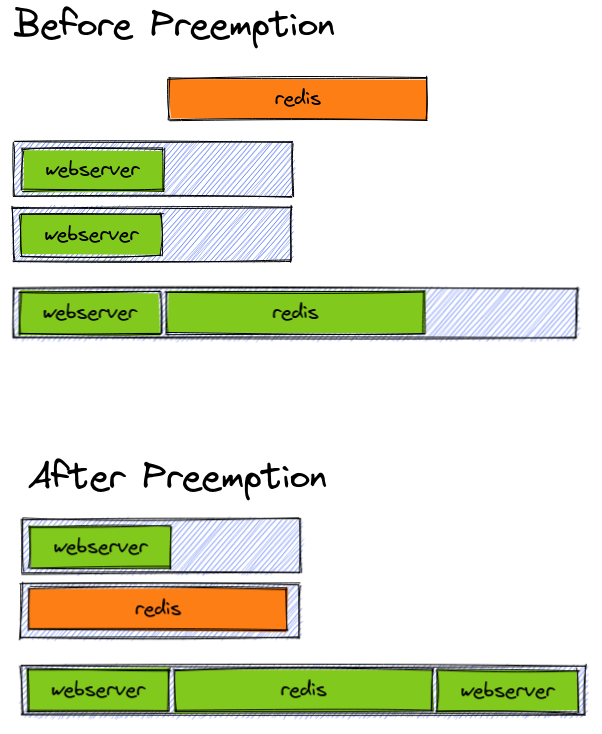

## Next steps

The process you learned in this tutorial can also be applied to
[batch](https://www.nomadproject.io/api-docs/operator/#batchschedulerenabled) jobs as well. Read more about preemption in the
[Nomad documentation](https://www.nomadproject.io/docs/internals/scheduling/preemption).

### Reference material

- [Preemption][preemption]

[batch-enabled]: https://www.nomadproject.io/api-docs/operator/#batchschedulerenabled
[batch-job]: https://www.nomadproject.io/docs/schedulers/#batch
[count]: https://www.nomadproject.io/docs/job-specification/group/#count
[enterprise]: https://www.nomadproject.io/docs/enterprise
[memory]: https://www.nomadproject.io/docs/job-specification/resources#memory
[payload-preemption-config]: https://www.nomadproject.io/api-docs/operator#sample-payload-1
[preemption-config]: https://www.nomadproject.io/api-docs/operator#preemptionconfig-1
[preemption]: https://www.nomadproject.io/docs/internals/scheduling/preemption
[priority]: https://www.nomadproject.io/docs/job-specification/job#priority
[repository]: https://github.com/hashicorp/nomad/tree/master/terraform#provision-a-nomad-cluster-in-the-cloud
[scheduler-configuration]: https://www.nomadproject.io/api-docs/operator#read-scheduler-configuration
[service-enabled]: https://www.nomadproject.io/api-docs/operator#serviceschedulerenabled-1
[service-job]: https://www.nomadproject.io/docs/schedulers#service
[step-1]: #create-a-job-with-low-priority
[system-job]: https://www.nomadproject.io/docs/schedulers#system
[t2-micro]: https://aws.amazon.com/ec2/instance-types/
[update-scheduler]: https://www.nomadproject.io/api-docs/operator#update-scheduler-configuration
[`nomad job plan` command]: https://www.nomadproject.io/docs/commands/job/plan
[`nomad job run` command]: https://www.nomadproject.io/docs/commands/job/run
[`nomad job status` command]: https://www.nomadproject.io/docs/commands/job/status
[`nomad job stop` command]: https://www.nomadproject.io/docs/commands/job/stop
[api-auth]: https://www.nomadproject.io/api-docs#authentication


# Clean Up

## terraform destroy

In [ ]:
pushd /tmp/nomad_terraform/aws/env
time terragrunt destroy > /tmp/tf_destroy_nomad_out.txt 2>&1 &
popd

In [ ]:
tail -n 50 /tmp/tf_destroy_nomad_out.txt

In [ ]:
rm /tmp/nomad_terraform/aws/env/terraform.tfstate*

In [ ]:
rm /tmp/nomad_terraform/jobs/traefik.nomad.bak_*

# Q&A

Hi SMEs! Is there any documentation around the behavior of updating the [scheduling algorithm](https://www.nomadproject.io/api-docs/operator/scheduler#update-scheduler-configuration) on a Nomad cluster from binpack to spread. Specifically, are allocs spread when redeployed or does Nomad try to balance things proactively after the setting is applied?

Correct, the scheduling change is only forward looking. The best answer to get things spread after the fact is a set of rolling-drains.

Daniel Santos
We did this in our Prod Nomad clusters a couple weeks ago and the spread behaviour applies only after new allocs / evals are placed

# References

- Variable Interpolation - https://www.nomadproject.io/docs/runtime/interpolation
- Node Variables - https://www.nomadproject.io/docs/runtime/interpolation#interpreted_node_vars

```
nomad node status -verbose -self
```

### Vault

In [ ]:
ssh -i /tmp/nomad_terraform/ssh_key/aws-key-pair \
  -o StrictHostKeyChecking=no ubuntu@54.189.139.194 \
  dig @127.0.0.1 -p 8600 active.vault.service.consul

In [ ]:
ssh -i /tmp/nomad_terraform/ssh_key/aws-key-pair \
  -o StrictHostKeyChecking=no ubuntu@54.189.139.194 \
  VAULT_ADDR=http://127.0.0.1:8200 vault status

# Changelog

2022-09-08
- Packer
  - I disabled nvidia docker and rkt install
  - switched to `ubuntu-focal-20.04` from `ubuntu-xenial-16.04`
  - switched to spot instance. m5.xlarge vs t2
  ```json
    "spot_instance_types": ["m5.large"],
    "spot_price": "auto",
  ```
  - removed `dns-port` from consul service file
  - switched `setup_new.sh` from `setup.sh`
- Terraform
  - Change aws provider to `3.75.2`